<a href="https://colab.research.google.com/github/cristianmejia00/clustering/blob/main/06_heatmap_sankey/01_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heatmap for Topic Modeling with BERTopic


# Requirements

## Packages installation and initialization

In [ ]:
#!pip install bertopic[visualization]

In [2]:
import pandas as pd
import time
import math
from datetime import date
import uuid
import re
import os
import json
import pickle
from itertools import compress
from bertopic import BERTopic
from umap import UMAP
#from gensim.parsing.preprocessing import remove_stopwords
import numpy as np
from sklearn.cluster import KMeans

In [51]:
# Change to the name of the folder in your Google Drive
root_folder_name = 'Bibliometrics_Drive'
#ROOT_FOLDER_PATH = f"drive/MyDrive/{root_folder_name}" # <- Google Colab
ROOT_FOLDER_PATH = f"/Users/cristian/Library/CloudStorage/GoogleDrive-cristianmejia00@gmail.com/My Drive/{root_folder_name}" #Mac

## Connect your Google Drive

In [52]:
# from google.colab import drive
# drive.mount('/content/drive')

In [53]:
# Function to save object to a pickle file
def save_object_as_pickle(obj, filename):
  """
  Saves an object as a pickle file.

  Args:
      obj: The object to be saved.
      filename: The filename of the pickle file.
  """
  with open(filename, "wb") as f:
    pickle.dump(obj, f)



In [54]:
# Function to load pickle object given a path
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


In [55]:
def save_heatmap_settings_as_json(heatmap_settings, filename="heatmap_settings.json"):
  """Saves heatmap settings as a JSON file with pretty indentation.

  Args:
      heatmap_settings: The heatmap settings dictionary.
      filename: The name of the JSON file.
  """
  with open(filename, "w") as f:
    json.dump(heatmap_settings, f, indent=4)



---



## PART 3: Merging Topic Models

# 🔴 Input files and options



In [56]:
heatmap_settings = {
    'metadata': {
      'heatmap_analysis_id': 'H016',
      'heatmap_name': 'Brain_Health',
      'date': '2026-12-22',
      'created_by': 'cristianmejia00@gmail.com',
      'notes': '',
      'input_directory': '',
      'output_directory': ''
    },
    'global': {
                'min_cluster_size': 10,
                'seed': 100,
                'transformer_model': 'all-MiniLM-L6-v2',
                'sankey_threshold': 0.7
              },
    'inputs': [
        {
            'project_folder_name': 'Q10_brain_health_ts_20250501',
            'analysis_folder_name': 'a01_cn__f01_dc__c01_lv',
            'level_folder_name': 'level1',
            'embeddings_folder_name': 'f01/e01',
            'display_name': 'BH',
            'cluster_column': 'Cluster Code',
            'heatmap_display_order': 0,
            'sankey_display_order': 0,
            'color': "#E9571F"
        }
      ]
}

In [57]:
# Save settings
save_heatmap_settings_as_json(heatmap_settings, filename=f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/heatmap_settings_{heatmap_settings["metadata"]["heatmap_analysis_id"]}_{heatmap_settings["metadata"]["heatmap_name"]}.json')

In [58]:
f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}'

'/Users/cristian/Library/CloudStorage/GoogleDrive-cristianmejia00@gmail.com/My Drive/Bibliometrics_Drive/H016'

In [59]:
heatmap_input_dfs = []
for tm in heatmap_settings['inputs']:
  document_path = f'{ROOT_FOLDER_PATH}/{tm["project_folder_name"]}/{tm["analysis_folder_name"]}/louvain/0.9/{tm["level_folder_name"]}/article_report.csv'
  #document_path = f'{ROOT_FOLDER_PATH}/{tm["project_folder_name"]}/{tm["analysis_folder_name"]}/{tm["level_folder_name"]}/article_report.csv'
  print(document_path)
  input_df = pd.read_csv(document_path,
                         usecols=['ID', 'uuid', tm['cluster_column']], 
                         encoding='latin-1')
  # Each dataset can use different clustering result e.g. X_C, level0, level1, so we need to unify the header name for concatenation
  input_df['display_name'] = tm['display_name']
  input_df['cluster'] = input_df['display_name'] + "-" + input_df[tm['cluster_column']].astype(str)
  input_df = input_df.rename(columns={'ID': 'UT'})
  input_df = input_df.drop(columns=[tm['cluster_column']])
  heatmap_input_dfs.append(input_df)

/Users/cristian/Library/CloudStorage/GoogleDrive-cristianmejia00@gmail.com/My Drive/Bibliometrics_Drive/Q10_brain_health_ts_20250501/a01_cn__f01_dc__c01_lv/louvain/0.9/level1/article_report.csv


In [60]:
document_info = pd.concat(heatmap_input_dfs).reset_index(drop=True)
print(len(document_info))
document_info.head()

6460


,UT,uuid,display_name,cluster
0,WOS:000236554800002,362a101d-0953-441d-84d3-871ed2bbffe0,BH,BH-1-1---
1,WOS:000305341700054,5fded946-82ee-45c0-80ab-ede90fd6ed1b,BH,BH-1-1---
2,WOS:000240322400010,4862867e-2217-4bac-8f61-92b443339860,BH,BH-1-1---
3,WOS:000276216800011,539246f5-70dc-4995-8a66-488b96a6cd5e,BH,BH-1-1---
4,WOS:000268330500005,8a4a2be2-5320-4b16-86d7-5f1ccdbdeaef,BH,BH-1-1---


In [61]:
document_info.tail()

,UT,uuid,display_name,cluster
6455,WOS:000923546400052,1a6eaf97-49fd-4948-8107-cb596a5afac9,BH,BH-99-99---
6456,WOS:001061198000008,321d50b3-316c-42b0-a332-d970ca7608a4,BH,BH-99-99---
6457,WOS:001061198000029,39d117d1-dd29-4abf-afb5-1eab8fb3a558,BH,BH-99-99---
6458,WOS:000664115400121,2607324c-8285-4d4a-9e32-7aecb3c4ccda,BH,BH-99-99---
6459,WOS:000469959500005,caec32e4-5410-4c1f-a0d4-6aa3285c4c8e,BH,BH-99-99---




---



## PART 5. Heatmap

In [62]:
# For firms we know, simply get the embeddings back.
embeddings_list = []
corpus_list = []
for tm in heatmap_settings['inputs']:
  print(f"=================Loading: {tm['project_folder_name']}")
  embeddings = load_pickle(f"{ROOT_FOLDER_PATH}/{tm['project_folder_name']}/{tm['embeddings_folder_name']}/embeddings.pck")
  if type(embeddings) == dict:
    print('Dict type found')
    embeddings = embeddings['embeddings']
    print("embeddings:", len(embeddings))
  corpus_tmp = pd.read_csv(f"{ROOT_FOLDER_PATH}/{tm['project_folder_name']}/{tm['embeddings_folder_name']}/corpus.csv")
  print("documents:", len(corpus_tmp))
  
  embeddings_list.append(embeddings)
  corpus_list.append(corpus_tmp)

=================Loading: Q10_brain_health_ts_20250501
Dict type found
embeddings: 8565
documents: 8565


In [64]:
# Combine embeddings
embeddings_uploaded = np.vstack(embeddings_list)
corpus_uploaded = pd.concat(corpus_list).reset_index(drop=True)

In [65]:
# Count df lengths
print(len(embeddings_uploaded))
print(len(corpus_uploaded))
print(len(document_info))

8565
8565
6460


In [66]:
# prompt: add `embeddings_uploaded` as a column to `corpus_uploaded`
corpus_uploaded['embeddings'] = list(embeddings_uploaded)
corpus_uploaded.head()

,text,UT,uuid,embeddings
0,The impact of cognitive reserve on cognitive o...,WOS:000375471800099,7cc8aa36-8303-452d-bca6-08ea94f8ad7f,"[0.08475498, 0.0018311654, -0.0055272523, -0.0..."
1,Imaging Cognitive Reserve FrontoParietal Conne...,WOS:000275274000051,7f34d364-b244-4ce4-b260-e780455ac588,"[0.098979, -0.05353425, -0.035051484, 0.016788..."
2,Impact of cognitive reserve on the relationshi...,WOS:000254576600014,b7da215d-3cfe-4df9-8346-53ebe6aa60da,"[0.08084235, -0.011479594, -0.018046426, 0.030..."
3,Cognitive reserve in substance addicts in trea...,WOS:000347214000001,628d94fe-5540-4d47-9b24-f585ed07de2b,"[0.06398768, -0.021486485, -0.035614178, 0.062..."
4,Cognitive reserve neuropathology and progressi...,WOS:001035308800004,747ee008-0ac3-4d20-a73c-e4514f3bc0b6,"[-0.010824714, -0.07128371, -0.038133714, 0.03..."


In [67]:
# Remove rows where 'UT' is duplicated, keeping the first occurrence
corpus_uploaded = corpus_uploaded.drop_duplicates(subset=['uuid'], keep='first')
corpus_uploaded.tail()

,text,UT,uuid,embeddings
8560,Comparison of Sleep Apnea Questionnaires and R...,WOS:001300283300001,958e12de-c502-4f9b-8e0e-a2ca7f0aaec6,"[0.02058737, -0.015006773, -0.010947479, 0.058..."
8561,Vitamin and mineral supplementation for preven...,WOS:000455159600020,75bb98cc-198c-4f29-963f-755b0ec43313,"[-0.010954423, 0.02992854, -0.039858162, 0.056..."
8562,Vitamin and mineral supplementation for mainta...,WOS:000455302700002,4064a676-96ed-460f-b30d-e0f2b2c67565,"[0.012075577, -0.0030420371, -0.050218333, 0.0..."
8563,In vitro comparison of major memorysupport die...,WOS:000623871300001,96e98d01-d311-465b-8ba0-845b6d325ad4,"[0.03311266, -0.07074771, -0.030034529, 0.0645..."
8564,Elective freezing of embryos versus fresh embr...,WOS:000763007300009,148ee1b3-d6c6-4cdd-807a-638ce3983c94,"[-0.015653055, -0.033114802, -0.03877956, 0.01..."


In [68]:
# prompt: merge `corpus_uploaded` and `document_info` by column uuid. The merged data frame has as many rows and same sorting as corpus_uploaded. The merged data frame is named `full_corpus`.
full_corpus = pd.merge(document_info[['UT', 'cluster']], corpus_uploaded[['UT', 'text', 'embeddings']], on='UT', how='left')
print(len(full_corpus))
full_corpus.tail()

6460


,UT,cluster,text,embeddings
6455,WOS:000923546400052,BH-99-99---,Age and Gender Differences in the Cognitive Re...,"[0.12594049, -0.0083380705, -0.04772415, 0.015..."
6456,WOS:001061198000008,BH-99-99---,TrafficRelated Air Pollution and Incident Deme...,"[0.09438883, -0.0010144034, 0.009067763, 0.073..."
6457,WOS:001061198000029,BH-99-99---,Air Pollution Stress and Allostatic Load Linki...,"[0.013628018, -0.0047699413, 0.026400484, 0.09..."
6458,WOS:000664115400121,BH-99-99---,ULTRAFINE PARTICLES AND THEIR POSSIBLE ROLE IN...,"[0.024152564, -0.068752415, 0.015748693, 0.029..."
6459,WOS:000469959500005,BH-99-99---,The End of the Beginning of the Alzheimers Dis...,"[-0.048184413, -0.045833174, -0.041390203, -0...."


In [69]:
len(full_corpus) == len(document_info)

True

In [70]:
# prompt: Remove all rows in full_corpus where the size of column `embeddings` do not match 384
len(embeddings_uploaded[0])

# Add a new column 'vector_length' to store the size of the embeddings
full_corpus['vector_length'] = full_corpus['embeddings'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0)

# Display the first few rows to verify
full_corpus.head()

#full_corpus = full_corpus[full_corpus['embeddings'].apply(lambda x: len(x) == 384 if isinstance(x, list) or isinstance(x, np.ndarray) else False)]

,UT,cluster,text,embeddings,vector_length
0,WOS:000236554800002,BH-1-1---,Brain reserve and dementia a systematic review...,"[-0.0025208585, -0.007248292, -0.026816031, 0....",384
1,WOS:000305341700054,BH-1-1---,Education and Dementia in the Context of the C...,"[0.03834199, 0.012860901, -0.07652913, 0.04356...",384
2,WOS:000240322400010,BH-1-1---,Cognitive reserve and Alzheimer disease Epidem...,"[-0.019078886, -0.02525214, 0.0183916, 0.02954...",384
3,WOS:000276216800011,BH-1-1---,Cognition Reserve and Amyloid Deposition in No...,"[0.075308554, -0.05848867, -0.011638889, 0.037...",384
4,WOS:000268330500005,BH-1-1---,Early diagnosis of Alzheimers disease using co...,"[0.028609496, -0.066482276, -0.0015271746, 0.0...",384


In [71]:
full_corpus.vector_length.value_counts()

vector_length
384    6460
Name: count, dtype: int64

In [72]:
# Remodel the topic model
from bertopic.backend import BaseEmbedder
from bertopic.cluster import BaseCluster
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sentence_transformers import SentenceTransformer

In [73]:

cluster_idx_mapping = full_corpus.cluster.value_counts()
# This part is optional when we have datasets with small clusters
#cluster_idx_mapping = cluster_idx_mapping[cluster_idx_mapping >= heatmap_settings['global']['min_cluster_size']]
full_corpus = full_corpus[full_corpus.cluster.isin(cluster_idx_mapping.index.to_list())]
# cluster_idx_mapping

In [74]:
# Form the embbedings
my_embeddings = np.vstack(full_corpus['embeddings'].tolist())

In [75]:
# get text and topics
docs = full_corpus.text
cluster_list = full_corpus.cluster

In [76]:
idx_cluster = [cluster_idx_mapping.index.get_loc(i) for i in cluster_list]

In [77]:
len(idx_cluster) == len(docs) == len(my_embeddings)

True

# 🟢🟢

In [78]:
# Init "empty" models
embedding_model = SentenceTransformer(heatmap_settings["global"]["transformer_model"])
empty_dimensionality_model = BaseDimensionalityReduction()
empty_cluster_model = BaseCluster()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=empty_dimensionality_model,
        hdbscan_model=empty_cluster_model,
        ctfidf_model=ctfidf_model
)

In [79]:
topics, probs = topic_model.fit_transform(docs, my_embeddings, y=idx_cluster)

In [80]:
tm_summary = topic_model.get_topic_info()
tm_summary

,Topic,Count,Name,Representation,Representative_Docs
0,0,311,0_registry_football_bhr_hoarding,"[registry, football, bhr, hoarding, online, gm...",[Rehabilitation of executive function in chron...
1,1,253,1_education_ad_connectivity_alzheimers,"[education, ad, connectivity, alzheimers, fdgp...",[Left frontal hub connectivity delays cognitiv...
2,2,241,2_vitamin_dietary_supplements_diet,"[vitamin, dietary, supplements, diet, intake, ...",[Carbohydrates and Their Grain Sources A Revie...
3,3,233,3_resilience_proteins_ad_alzheimers,"[resilience, proteins, ad, alzheimers, synapti...",[Proteomewide Analyses Identified Cortical Pro...
4,4,232,4_cr_residual_resilience_tau,"[cr, residual, resilience, tau, reserve, patho...",[A robust brain signature region approach for ...
...,...,...,...,...,...
59,59,47,59_brainage_chronological_dot_bai,"[brainage, chronological, dot, bai, center, ag...",[Norm atlas of lifespan for age and cognitive ...
60,60,46,60_personality_dispersion_openness_traits,"[personality, dispersion, openness, traits, ec...",[Brain Health Attitudes towards Technology Ado...
61,61,46,61_sitting_sedentary_breaks_sit,"[sitting, sedentary, breaks, sit, prolonged, m...",[Interacting effects of exercise with breaks i...
62,62,45,62_episcores_dnam_greenspace_hdlc,"[episcores, dnam, greenspace, hdlc, ses, neigh...",[Pathways explaining racialethnic and socioeco...


In [81]:
# Document information. Including the topic assignation
test = topic_model.get_document_info(docs, df = full_corpus)
test = test[['cluster', 'Name']].drop_duplicates(subset=['cluster'], keep='first')
test['short_name'] = test['Name'].str[:7]
test['dataset'] = test['cluster'].str.split('-').str[0]
print(test.shape)
test.head(20)

(64, 4)


,cluster,Name,short_name,dataset
0,BH-1-1---,1_education_ad_connectivity_alzheimers,1_educa,BH
253,BH-1-2---,4_cr_residual_resilience_tau,4_cr_re,BH
485,BH-1-3---,6_neural_task_cr_compensation,6_neura,BH
695,BH-1-4---,7_cr_reserve_questionnaire_criq,7_cr_re,BH
887,BH-1-5---,19_dt_pwb_divergent_gait,19_dt_p,BH
994,BH-1-99---,5_education_scd_wmh_cr,5_educa,BH
1209,BH-2-1---,12_crf_fitness_cardiorespiratory_exercise,12_crf_,BH
1356,BH-2-2---,13_exercise_bdnf_lactate_aerobic,13_exer,BH
1501,BH-2-3---,16_fasting_intermittent_energy_restriction,16_fast,BH
1616,BH-2-4---,17_bdnf_exercise_neurotrophic_irisin,17_bdnf,BH




---



In [82]:
# Default
# Visualize topic similarity using heatmap (self similarity)
hm = topic_model.visualize_heatmap()
#hm.write_html(f"{ROOT_FOLDER_PATH}/heatmap_updated.html")
hm

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_registry_football_bhr, 1_education_ad_connectivity,
                    2_vitamin_dietary_supplements, 3_resilience_proteins_ad,
                    4_cr_residual_resilience, 5_education_scd_wmh,
                    6_neural_task_cr, 7_cr_reserve_questionnaire,
                    8_bilingualism_bilingual_bi..., 9_exercise_creatine_training,
                    10_hearing_loneliness_activ..., 11_hiv_cancer_hand,
                    12_crf_fitness_cardiorespir..., 13_exercise_bdnf_lactate,
                    14_ms_sclerosis_multiple, 15_bipolar_bd_disorder,
                    16_fasting_intermittent_ene..., 17_bdnf_exercise_neurotrophic,
                    18_delirium_postoperative_p..., 19_dt_pwb_divergent,
                    20_neurovascular_cerebral_c..., 21_tbi_injury_traumatic,
                    22_osa_apnea_obstructive, 23_lc_coeruleus_locus,
                    24_nafld_liver_fibrosis, 25_gut_microbiota_microbiome,
                    26_poverty_childhood_cses, 27_neurology_ean_bcs,
                    28_hypertension_midlife_pre..., 29_about_knowledge_awareness,
                    30_cirrhosis_he_ee, 31_gut_microbiota_axis,
                    32_children_academic_fitness, 33_postexercise_min_cbf,
                    34_pd_parkinsons_motor, 35_complexity_occupational_...,
                    36_omega_dietary_diet, 37_leisure_tmt_wave,
                    38_prediction_brainage_chro..., 39_fighters_head_professional,
                    40_sleep_pvs_gpld, 41_walnuts_food_mind,
                    42_libra_modifiable_lifestyle, 43_social_isolation_contact,
                    44_stroke_poststroke_retinal, 45_polyphenols_cocoa_resver...,
                    46_amd_services_prevention, 47_cvh_ls_ideal,
                    48_exercise_aerobic_physical, 49_women_sex_men,
                    50_asthma_circumference_head, 51_prevalence_mortality_ascvd,
                    52_bilingualism_bilingual_l..., 53_schizophrenia_iq_psychosis,
                    54_als_frontotemporal_bvftd, 55_omega_dha_pufa,
                    56_womens_menopause_vms, 57_barcelona_dualtask_bbhi,
                    58_fructose_metals_concentr..., 59_brainage_chronological_dot,
                    60_personality_dispersion_o..., 61_sitting_sedentary_breaks,
                    62_episcores_dnam_greenspace, 63_bcr_hd_tg],
              'xaxis': 'x',
              'y': [0_registry_football_bhr, 1_education_ad_connectivity,
                    2_vitamin_dietary_supplements, 3_resilience_proteins_ad,
                    4_cr_residual_resilience, 5_education_scd_wmh,
                    6_neural_task_cr, 7_cr_reserve_questionnaire,
                    8_bilingualism_bilingual_bi..., 9_exercise_creatine_training,
                    10_hearing_loneliness_activ..., 11_hiv_cancer_hand,
                    12_crf_fitness_cardiorespir..., 13_exercise_bdnf_lactate,
                    14_ms_sclerosis_multiple, 15_bipolar_bd_disorder,
                    16_fasting_intermittent_ene..., 17_bdnf_exercise_neurotrophic,
                    18_delirium_postoperative_p..., 19_dt_pwb_divergent,
                    20_neurovascular_cerebral_c..., 21_tbi_injury_traumatic,
                    22_osa_apnea_obstructive, 23_lc_coeruleus_locus,
                    24_nafld_liver_fibrosis, 25_gut_microbiota_microbiome,
                    26_poverty_childhood_cses, 27_neurology_ean_bcs,
                    28_hypertension_midlife_pre..., 29_about_knowledge_awareness,
                    30_cirrhosis_he_ee, 31_gut_microbiota_axis,
                    32_children_academic_fitness, 33_postexercise_min_cbf,
                    34_pd_parkinsons_motor, 35_complexity_occupational_...,
                    36_omega_dietary_diet, 37_leisure_tmt_wave,
          

In [83]:
#pd.DataFrame(hm.data[0]['z'], columns=hm.data[0]['x']).to_csv(f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/heatmap_matrix.csv', index=False)



---



## coordinates

In [84]:
# The code adjusts the similarity matrix to ignore (set to 0) similarities between items that belong to the same dataset. This might be useful in scenarios where intra-dataset similarities are not meaningful or should be excluded from further analysis.
label_dataset = []
for i, label in enumerate(hm.data[0]['x']):
    short_label = label[:7]
    label_dataset.append(test[test['short_name'] == short_label]['dataset'].iloc[0])

updated_matrix = []
for this_line, current_sim_values in enumerate(hm.data[0]['z']):
    updated_sim_values = [0 if label_dataset[i] == label_dataset[this_line] else x for i, x in enumerate(current_sim_values)]
    updated_matrix.append(updated_sim_values)

updated_matrix = np.array(updated_matrix)
updated_matrix


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(64, 64))

In [85]:
import numpy as np
import umap

def reduce_dimensionality(data):
    # Create a UMAP object with the desired settings
    reducer = umap.UMAP(n_components=2, random_state=heatmap_settings['global']['seed'], metric='cosine', min_dist=0.65, n_neighbors=25, n_epochs=1500, verbose=True)

    # Perform dimensionality reduction
    reduced_data = reducer.fit_transform(data)

    return reduced_data

---

In [86]:
# Reduce dimensionality using UMAP
reduced_data = reduce_dimensionality(hm.data[0]['z'])
#reduced_data = reduce_dimensionality(updated_matrix) 
# Print the shape of the reduced data
print("Reduced data shape:", reduced_data.shape)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.65, n_epochs=1500, n_jobs=1, n_neighbors=25, random_state=100, verbose=True)
Thu Jan 22 12:46:19 2026 Construct fuzzy simplicial set
Thu Jan 22 12:46:19 2026 Finding Nearest Neighbors
Thu Jan 22 12:46:19 2026 Finished Nearest Neighbor Search
Thu Jan 22 12:46:19 2026 Construct embedding


Epochs completed:  47%| ████▋      705/1500 [00:00]

	completed  0  /  1500 epochs
	completed  150  /  1500 epochs
	completed  300  /  1500 epochs
	completed  450  /  1500 epochs
	completed  600  /  1500 epochs
	completed  750  /  1500 epochs
	completed  900  /  1500 epochs
	completed  1050  /  1500 epochs
	completed  1200  /  1500 epochs


Epochs completed: 100%| ██████████ 1500/1500 [00:00]

	completed  1350  /  1500 epochs
Thu Jan 22 12:46:19 2026 Finished embedding
Reduced data shape: (64, 2)


In [87]:
# Here's a dangerous procedure. We are appending the names of the clusters without veryfying the order in the heatmap.
dms = pd.DataFrame(reduced_data)
dms.columns = ['x', 'y']
dms['label'] = tm_summary['Name'] # Here. We need to ensure the order. If the heatmap change the order of the cluster like by applying the heatmap clustered, then this code will fail.
dms['cluster'] = dms['label'].map(test.set_index('Name')['cluster'])
dms.head()

,x,y,label,cluster
0,-1.234971,6.047550,0_registry_football_bhr_hoarding,BH-99-99---
1,-2.767211,5.720402,1_education_ad_connectivity_alzheimers,BH-1-1---
2,1.407847,8.628775,2_vitamin_dietary_supplements_diet,BH-4-99---
3,-0.490589,6.700047,3_resilience_proteins_ad_alzheimers,BH-9-0---
4,-3.456711,5.940589,4_cr_residual_resilience_tau,BH-1-2---


In [88]:
# Save dms
dms.to_csv(f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/coordinates.csv', index = False)

In [89]:
# Save heatmap
pd.DataFrame(hm.data[0]['z'], columns=dms["cluster"]).to_csv(f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/heatmap_matrix.csv', index=False)

In [90]:
dms['dataset'] = dms['cluster'].str.split('-').str[0]
dms.head(10)

,x,y,label,cluster,dataset
0,-1.234971,6.047550,0_registry_football_bhr_hoarding,BH-99-99---,BH
1,-2.767211,5.720402,1_education_ad_connectivity_alzheimers,BH-1-1---,BH
2,1.407847,8.628775,2_vitamin_dietary_supplements_diet,BH-4-99---,BH
3,-0.490589,6.700047,3_resilience_proteins_ad_alzheimers,BH-9-0---,BH
4,-3.456711,5.940589,4_cr_residual_resilience_tau,BH-1-2---,BH
5,-3.580881,5.185731,5_education_scd_wmh_cr,BH-1-99---,BH
6,-2.542483,4.970303,6_neural_task_cr_compensation,BH-1-3---,BH
7,-5.144835,5.125832,7_cr_reserve_questionnaire_criq,BH-1-4---,BH
8,-4.092486,5.852307,8_bilingualism_bilingual_bilinguals_language,BH-8-99---,BH
9,-0.714033,10.548332,9_exercise_creatine_training_ms,BH-2-99---,BH


In [91]:
cluster_counts = dms['cluster'].value_counts().sort_index()
print(cluster_counts)

cluster
BH-1-1---      1
BH-1-2---      1
BH-1-3---      1
BH-1-4---      1
BH-1-5---      1
              ..
BH-99-2---     1
BH-99-3---     1
BH-99-4---     1
BH-99-5---     1
BH-99-99---    1
Name: count, Length: 64, dtype: int64


In [92]:
!pip install seaborn

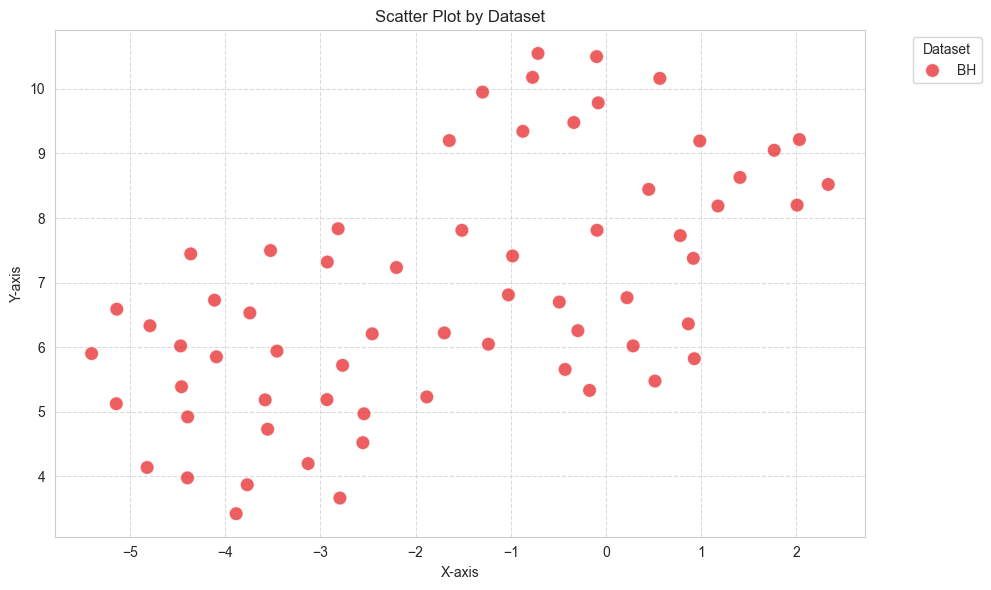

In [93]:
from turtle import color
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with different colors for each dataset
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dms, x='x', y='y', s=100, hue='dataset', palette='Set1', alpha=0.7)
plt.title('Scatter Plot by Dataset')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True, linestyle='--', alpha=0.7)
# Add legend
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
# Improve appearance
sns.set_style("whitegrid")
plt.tight_layout()
# Show the plot
plt.show()



---



## Melted

In [94]:
# prompt: `hm_test` is a squared matrix similarity matrix. This is a symmetric matrix so we only consider the lower triangle, without the diagonal.  Let's get the melted form as a data frame with 3 columns `Source`, `Target`, and `Similarity`. Then, sort it from the largest similarity to the lowest. Remove the pairs with value of zero.
hm_test = hm.data[0]['z']

# Assuming hm_test is your similarity matrix
df = pd.DataFrame(hm_test)

# Get the lower triangle without the diagonal
rows, cols = np.tril_indices(df.shape[0], -1)

# Create a DataFrame with Source, Target, and Similarity
similarity_df = pd.DataFrame({
    'Source': df.columns[rows],
    'Target': df.columns[cols],
    'Similarity': df.values[rows, cols]
})

# Remove rows with similarity of zero
similarity_df = similarity_df[similarity_df['Similarity'] > 0]

# Sort by similarity in descending order
similarity_df = similarity_df.sort_values('Similarity', ascending=False)

similarity_df

,Source,Target,Similarity
14,5,4,0.981955
11,5,1,0.980961
7,4,1,0.976909
178,19,7,0.970818
49,10,4,0.966811
...,...,...,...
1365,52,39,0.415195
772,39,31,0.391372
766,39,25,0.382359
1351,52,25,0.381451


In [95]:
# prompt: Using dataframe similarity_df: Replace the values of columns Source and Target with the labels from `dms["cluster"]`

# Replace Source and Target with labels from dms["cluster"]
similarity_df['Source'] = similarity_df['Source'].map(lambda x: dms["cluster"][int(x)]) # Convert x to integer
similarity_df['Target'] = similarity_df['Target'].map(lambda x: dms["cluster"][int(x)]) # Convert x to integer


In [96]:
similarity_df.head(100)

,Source,Target,Similarity
14,BH-1-99---,BH-1-2---,0.981955
11,BH-1-99---,BH-1-1---,0.980961
7,BH-1-2---,BH-1-1---,0.976909
178,BH-1-5---,BH-1-4---,0.970818
49,BH-5-99---,BH-1-2---,0.966811
...,...,...,...
803,BH-3-5---,BH-7-99---,0.917662
439,BH-6-99---,BH-1-2---,0.917353
436,BH-6-99---,BH-1-1---,0.917142
1436,BH-99-5---,BH-1-99---,0.916878


In [ ]:
# # prompt: Using dataframe similarity_df: Replace the values of columns Source and Target with the corresponding "cluster" in the `dms` data frame. Use the column "label" in `dms` to find the matches.

# # Assuming you have a dataframe named 'dms' with 'label' and 'cluster' columns

# # Create a dictionary mapping 'label' to 'cluster' from the 'dms' dataframe
# label_to_cluster = dict(zip(dms['label'], dms['cluster']))

# # Replace 'Source' column values with corresponding 'cluster' values
# similarity_df['Source'] = similarity_df['Source'].map(label_to_cluster)

# # Replace 'Target' column values with corresponding 'cluster' values
# similarity_df['Target'] = similarity_df['Target'].map(label_to_cluster)

# similarity_df.head()

In [98]:
similarity_df.to_csv(f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/heatmap_melted.csv', index = False)